In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')
plt.rcParams["font.family"] = "Times New Roman"

In [2]:
import time
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score
from scipy.stats import gmean, rankdata

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(
        100 * (start_mem - end_mem) / start_mem))

    return df

In [4]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
client_profile = reduce_mem_usage(pd.read_csv('data/client_profile.csv'))
print('*'*100)
print("train.shape = {} rows, {} cols".format(*train.shape))
print("test.shape = {} rows, {} cols".format(*test.shape))
print("client_profile.shape = {} rows, {} cols".format(*client_profile.shape))

Memory usage of dataframe is 45.78 MB
Memory usage after optimization is: 18.12 MB
Decreased by 60.4%
****************************************************************************************************
train.shape = 110093 rows, 3 cols
test.shape = 165141 rows, 2 cols
client_profile.shape = 250000 rows, 24 cols


In [5]:
train = train.merge(client_profile, on='APPLICATION_NUMBER', how='left')
test = test.merge(client_profile, on='APPLICATION_NUMBER', how='left')
target = train['TARGET']

In [7]:
train_dum = pd.get_dummies(train)
test_dum = pd.get_dummies(test)

*******************

1) Обучить алгоритмы LightGBM и XGBoost, получить OOF прогнозы, оценить корреляцию прогнозов на обучающей выборке. Применить модели на тестовую выборку и оценить корреляцию.

In [8]:
def xgboost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели xgboost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

#     if categorical:
#         for feature in categorical:
#             encoder = LabelEncoder()
#             X[feature] = encoder.fit_transform(X[feature].astype("str").fillna("NA"))

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        
        dtrain = xgb.DMatrix(x_train, y_train)
        dvalid = xgb.DMatrix(x_valid, y_valid)

        model = xgb.train(
            params=params,
            dtrain=dtrain,
            maximize=True,
            num_boost_round=10000,
            early_stopping_rounds=100,
            evals=[(dtrain, "train"), (dvalid, "valid")],
            verbose_eval=100,
        )
        oof_preds[valid_idx] = model.predict(dvalid)
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        folds_scores.append(round(score, 5))
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        estimators.append(model)
    print(f"Score by each fold: {folds_scores}")
    print(f"Mean score by each fold:{sum(folds_scores)/len(folds_scores)}")
    print("="*65)

    return estimators, oof_preds

In [13]:
xgb_params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.01,
     "reg_alpha": 0.05,
    'reg_lambda': 0.06,
    "max_depth": 6,
    "gamma": 10,
    "nthread": -1,
    "seed": 13
}

In [14]:
cv_strategy = KFold(n_splits=7, random_state=13, shuffle=True)

In [17]:
estimators_xgb, oof_score_xgb = xgboost_cross_validation(
    xgb_params, train_dum.drop(columns='TARGET'), target,  cv=cv_strategy
)

Sun Oct 24 13:42:07 2021, Cross-Validation, 110093 rows, 37 cols
[0]	train-auc:0.69135	valid-auc:0.68248
[100]	train-auc:0.71124	valid-auc:0.69404
[200]	train-auc:0.71982	valid-auc:0.69914
[300]	train-auc:0.73073	valid-auc:0.70405
[400]	train-auc:0.73833	valid-auc:0.70830
[500]	train-auc:0.74582	valid-auc:0.71121
[600]	train-auc:0.74926	valid-auc:0.71324
[700]	train-auc:0.75038	valid-auc:0.71311
[716]	train-auc:0.75038	valid-auc:0.71311
Fold 1, Valid score = 0.71311
[0]	train-auc:0.68864	valid-auc:0.68400
[100]	train-auc:0.71011	valid-auc:0.70417
[200]	train-auc:0.71991	valid-auc:0.70813
[300]	train-auc:0.72933	valid-auc:0.71189
[400]	train-auc:0.73908	valid-auc:0.71518
[500]	train-auc:0.74584	valid-auc:0.71692
[600]	train-auc:0.74895	valid-auc:0.71800
[700]	train-auc:0.74917	valid-auc:0.71846
[759]	train-auc:0.74917	valid-auc:0.71846
Fold 2, Valid score = 0.71846
[0]	train-auc:0.69008	valid-auc:0.68333
[100]	train-auc:0.71088	valid-auc:0.70981
[200]	train-auc:0.71882	valid-auc:0.71173

In [18]:
def lightgbm_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели lightgbm.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """

            
    estimators, folds_scores = [], []
    
    if not categorical:
        categorical = "auto"

    oof_preds = np.zeros(X.shape[0])
    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        
        model = lgb.LGBMClassifier(**params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],
            eval_metric="auc", 
            verbose=500, 
            early_stopping_rounds=500
        )
        
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
#         print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    print(f"Mean score by each fold:{sum(folds_scores)/len(folds_scores)}")
    return estimators, oof_preds

In [19]:
lgbm_params = {
    'metric':"auc", 
    'boosting_type': 'gbdt',
    'n_estimators': 3000,
    'learning_rate': 0.01,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.5,
    'reg_lambda': 0.5,
    'colsample_bytree': 0.5,
    'min_split_gain': 0.01,
    'subsample': 0.7,
    'is_unbalance': False,
    'random_state': 13,
       
}

In [20]:
estimators_lgbm, oof_preds_lgbm = lightgbm_cross_validation(
    lgbm_params, train_dum.drop(columns='TARGET'), target, cv=cv_strategy, 
)

Sun Oct 24 14:14:28 2021, Cross-Validation, 110093 rows, 37 cols
Training until validation scores don't improve for 500 rounds
[500]	valid_0's auc: 0.715454
[1000]	valid_0's auc: 0.716982
[1500]	valid_0's auc: 0.717353
Early stopping, best iteration is:
[1192]	valid_0's auc: 0.717785
Training until validation scores don't improve for 500 rounds
[500]	valid_0's auc: 0.719074
Early stopping, best iteration is:
[135]	valid_0's auc: 0.721482
Training until validation scores don't improve for 500 rounds
[500]	valid_0's auc: 0.724723
[1000]	valid_0's auc: 0.725963
Early stopping, best iteration is:
[720]	valid_0's auc: 0.727084
Training until validation scores don't improve for 500 rounds
[500]	valid_0's auc: 0.722164
[1000]	valid_0's auc: 0.722713
Early stopping, best iteration is:
[741]	valid_0's auc: 0.723444
Training until validation scores don't improve for 500 rounds
[500]	valid_0's auc: 0.722633
Early stopping, best iteration is:
[215]	valid_0's auc: 0.723399
Training until validation

In [21]:
scores = pd.DataFrame({
    "lgbm": oof_preds_lgbm,
    "xgb": oof_score_xgb    
})

corr = scores.corr()

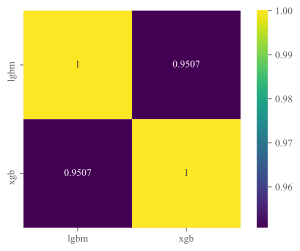

In [23]:
plt.figsize=(7, 7)
sns.heatmap(corr, annot=True, fmt=".4g", square=True, cmap="viridis")
plt.show()

In [27]:
prediction_xgb = np.zeros(test.shape[0])
for model in estimators_xgb:
    prediction_xgb+=model.predict(xgb.DMatrix(test_dum))
prediction_xgb = prediction_xgb/len(estimators_xgb)

prediction_lgbm = np.zeros(test.shape[0])
for model in estimators_lgbm:
    prediction_lgbm+=model.predict_proba(test_dum)[:, 1]
            
prediction_lgbm = prediction_lgbm/len(estimators_lgbm)

In [30]:
scores_preds = pd.DataFrame({
    "lgbm": prediction_lgbm,
    "xgb": prediction_xgb    
})

corr = scores_preds.corr()

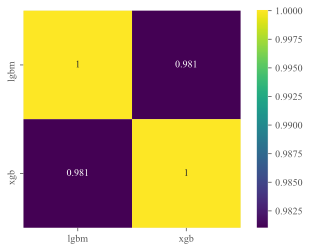

In [31]:
plt.figsize=(7, 7)
sns.heatmap(corr, annot=True, fmt=".4g", square=True, cmap="viridis")
plt.show()

на test корреляция между моделями довольно высокая - возможно эффект от ансамблирования будет незначительный

******************************

2) Усреднить прогнозы с помощью арифмитического среднего, геометрического среднего и усреднить ранги, сделать выводы о качестве отдельных моделей и о качестве комбинации.

In [32]:
#AMEAN
scores_mean = scores.mean(axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7198


In [33]:
#GMEAN
scores_mean = gmean(scores, axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7199


In [35]:
# Rankdata
scores_mean = scores.rank().mean(axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7196


In [37]:
scores_mean = gmean(scores.rank(), axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7198


Gmean показал лучшую метрику. Однако среди моделей lgbm показал результат лучше - для блендинга стоит подбирать веса предсказаний

-------------

3) Обучить CatBoost, получить OOF прогнозы и выполнить задание 1 для трех моделей.

In [38]:
def catboost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")
#     X[categorical] = X[categorical].astype(str)

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = cb.CatBoostClassifier(**params)
        model.fit(
            x_train, y_train, categorical,
            eval_set=[(x_train, y_train), (x_valid, y_valid)]
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print(f"Mean score by each fold:{sum(folds_scores)/len(folds_scores)}")
    print("="*65)
    return estimators, oof_preds

In [39]:
cb_params = {
    "n_estimators": 2000,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 10,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
}

In [41]:
estimators_cb, oof_preds_cb = catboost_cross_validation(
    params=cb_params, X=train_dum.drop(columns='TARGET'), y=target, cv=cv_strategy
)

Sun Oct 24 14:59:24 2021, Cross-Validation, 110093 rows, 37 cols
0:	test: 0.6136649	test1: 0.6074610	best: 0.6074610 (0)	total: 32.4ms	remaining: 1m 4s
10:	test: 0.6773284	test1: 0.6684406	best: 0.6727432 (7)	total: 240ms	remaining: 43.5s
20:	test: 0.6868141	test1: 0.6757588	best: 0.6757588 (20)	total: 449ms	remaining: 42.3s
30:	test: 0.6928841	test1: 0.6805439	best: 0.6805439 (30)	total: 666ms	remaining: 42.3s
40:	test: 0.6960897	test1: 0.6863732	best: 0.6863732 (40)	total: 891ms	remaining: 42.6s
50:	test: 0.6985783	test1: 0.6891537	best: 0.6891537 (50)	total: 1.12s	remaining: 42.7s
60:	test: 0.7013329	test1: 0.6913933	best: 0.6920246 (59)	total: 1.33s	remaining: 42.3s
70:	test: 0.7022867	test1: 0.6925926	best: 0.6927077 (69)	total: 1.6s	remaining: 43.5s
80:	test: 0.7024844	test1: 0.6928464	best: 0.6937530 (74)	total: 1.81s	remaining: 43s
90:	test: 0.7040092	test1: 0.6950114	best: 0.6950114 (90)	total: 2.04s	remaining: 42.8s
100:	test: 0.7051563	test1: 0.6970229	best: 0.6970229 (100)	

910:	test: 0.7370383	test1: 0.7142674	best: 0.7144185 (900)	total: 20.5s	remaining: 24.5s
920:	test: 0.7372355	test1: 0.7142337	best: 0.7144185 (900)	total: 20.7s	remaining: 24.3s
930:	test: 0.7374689	test1: 0.7141684	best: 0.7144185 (900)	total: 20.9s	remaining: 24s
940:	test: 0.7376929	test1: 0.7142160	best: 0.7144185 (900)	total: 21.2s	remaining: 23.8s
950:	test: 0.7379035	test1: 0.7142150	best: 0.7144185 (900)	total: 21.4s	remaining: 23.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7144184501
bestIteration = 900

Shrink model to first 901 iterations.
Fold 1, Valid score = 0.71442
0:	test: 0.6136749	test1: 0.6067439	best: 0.6067439 (0)	total: 30.6ms	remaining: 1m 1s
10:	test: 0.6749221	test1: 0.6633283	best: 0.6691636 (7)	total: 229ms	remaining: 41.4s
20:	test: 0.6836384	test1: 0.6778000	best: 0.6778000 (20)	total: 451ms	remaining: 42.5s
30:	test: 0.6910702	test1: 0.6852021	best: 0.6852021 (30)	total: 757ms	remaining: 48.1s
40:	test: 0.6941236	test1: 0.68833

110:	test: 0.7069025	test1: 0.7075283	best: 0.7075484 (108)	total: 3.24s	remaining: 55.1s
120:	test: 0.7075156	test1: 0.7090582	best: 0.7091163 (116)	total: 3.52s	remaining: 54.7s
130:	test: 0.7080431	test1: 0.7090838	best: 0.7095309 (123)	total: 3.85s	remaining: 54.9s
140:	test: 0.7082505	test1: 0.7094968	best: 0.7095309 (123)	total: 4.13s	remaining: 54.5s
150:	test: 0.7090965	test1: 0.7100253	best: 0.7100253 (150)	total: 4.43s	remaining: 54.3s
160:	test: 0.7099656	test1: 0.7110987	best: 0.7114306 (158)	total: 4.73s	remaining: 54.1s
170:	test: 0.7103474	test1: 0.7115583	best: 0.7115770 (168)	total: 5.02s	remaining: 53.7s
180:	test: 0.7105828	test1: 0.7124568	best: 0.7127408 (176)	total: 5.33s	remaining: 53.6s
190:	test: 0.7110779	test1: 0.7132620	best: 0.7133464 (185)	total: 5.63s	remaining: 53.3s
200:	test: 0.7116390	test1: 0.7147398	best: 0.7147398 (200)	total: 5.94s	remaining: 53.2s
210:	test: 0.7116567	test1: 0.7145201	best: 0.7147398 (200)	total: 6.23s	remaining: 52.8s
220:	test:

190:	test: 0.7133640	test1: 0.7060023	best: 0.7060552 (179)	total: 5.92s	remaining: 56s
200:	test: 0.7134868	test1: 0.7064671	best: 0.7067034 (199)	total: 6.26s	remaining: 56s
210:	test: 0.7141122	test1: 0.7065309	best: 0.7068409 (203)	total: 6.59s	remaining: 55.9s
220:	test: 0.7146310	test1: 0.7064715	best: 0.7072460 (216)	total: 6.96s	remaining: 56s
230:	test: 0.7154059	test1: 0.7075868	best: 0.7075868 (230)	total: 7.34s	remaining: 56.2s
240:	test: 0.7158150	test1: 0.7078020	best: 0.7078329 (238)	total: 7.71s	remaining: 56.3s
250:	test: 0.7163007	test1: 0.7081981	best: 0.7083743 (249)	total: 8.04s	remaining: 56s
260:	test: 0.7167295	test1: 0.7083678	best: 0.7085007 (254)	total: 8.46s	remaining: 56.4s
270:	test: 0.7171888	test1: 0.7085727	best: 0.7088407 (265)	total: 8.85s	remaining: 56.5s
280:	test: 0.7175683	test1: 0.7088562	best: 0.7089655 (277)	total: 9.27s	remaining: 56.7s
290:	test: 0.7180594	test1: 0.7092106	best: 0.7092570 (289)	total: 9.67s	remaining: 56.8s
300:	test: 0.71851

290:	test: 0.7168629	test1: 0.7134045	best: 0.7134047 (289)	total: 10.3s	remaining: 1m
300:	test: 0.7173256	test1: 0.7136248	best: 0.7136521 (299)	total: 10.6s	remaining: 59.9s
310:	test: 0.7176576	test1: 0.7139455	best: 0.7140283 (308)	total: 11s	remaining: 59.7s
320:	test: 0.7180959	test1: 0.7143177	best: 0.7143177 (320)	total: 11.4s	remaining: 59.5s
330:	test: 0.7183875	test1: 0.7147784	best: 0.7147784 (330)	total: 11.8s	remaining: 59.4s
340:	test: 0.7188528	test1: 0.7152202	best: 0.7152202 (340)	total: 12.1s	remaining: 59s
350:	test: 0.7194356	test1: 0.7153335	best: 0.7155110 (347)	total: 12.4s	remaining: 58.5s
360:	test: 0.7199592	test1: 0.7158995	best: 0.7158995 (360)	total: 12.8s	remaining: 58.2s
370:	test: 0.7204722	test1: 0.7162289	best: 0.7162289 (370)	total: 13.2s	remaining: 57.9s
380:	test: 0.7207696	test1: 0.7164329	best: 0.7164329 (380)	total: 13.6s	remaining: 57.6s
390:	test: 0.7212003	test1: 0.7168475	best: 0.7168475 (390)	total: 13.9s	remaining: 57.4s
400:	test: 0.7216

170:	test: 0.7110804	test1: 0.6962160	best: 0.6962996 (165)	total: 6.2s	remaining: 1m 6s
180:	test: 0.7117306	test1: 0.6968035	best: 0.6968183 (179)	total: 6.57s	remaining: 1m 6s
190:	test: 0.7123212	test1: 0.6972658	best: 0.6973907 (188)	total: 6.93s	remaining: 1m 5s
200:	test: 0.7127990	test1: 0.6975018	best: 0.6975292 (199)	total: 7.3s	remaining: 1m 5s
210:	test: 0.7135992	test1: 0.6985233	best: 0.6985233 (210)	total: 7.66s	remaining: 1m 4s
220:	test: 0.7143141	test1: 0.6987618	best: 0.6988016 (216)	total: 8.05s	remaining: 1m 4s
230:	test: 0.7146856	test1: 0.6990664	best: 0.6990707 (223)	total: 8.44s	remaining: 1m 4s
240:	test: 0.7151443	test1: 0.6995007	best: 0.6995007 (240)	total: 8.8s	remaining: 1m 4s
250:	test: 0.7153830	test1: 0.6998293	best: 0.6998293 (250)	total: 9.15s	remaining: 1m 3s
260:	test: 0.7160382	test1: 0.7004030	best: 0.7004030 (260)	total: 9.53s	remaining: 1m 3s
270:	test: 0.7166228	test1: 0.7013156	best: 0.7013156 (270)	total: 9.95s	remaining: 1m 3s
280:	test: 0.

1090:	test: 0.7392834	test1: 0.7167011	best: 0.7167438 (1080)	total: 42.2s	remaining: 35.1s
1100:	test: 0.7394994	test1: 0.7168508	best: 0.7168508 (1100)	total: 42.6s	remaining: 34.8s
1110:	test: 0.7396517	test1: 0.7169454	best: 0.7169663 (1109)	total: 42.9s	remaining: 34.4s
1120:	test: 0.7397350	test1: 0.7170027	best: 0.7170213 (1116)	total: 43.3s	remaining: 34s
1130:	test: 0.7398803	test1: 0.7172464	best: 0.7172584 (1128)	total: 43.7s	remaining: 33.6s
1140:	test: 0.7400764	test1: 0.7174156	best: 0.7174156 (1140)	total: 44s	remaining: 33.1s
1150:	test: 0.7402298	test1: 0.7175267	best: 0.7175267 (1150)	total: 44.4s	remaining: 32.7s
1160:	test: 0.7404247	test1: 0.7175439	best: 0.7175738 (1152)	total: 44.8s	remaining: 32.4s
1170:	test: 0.7405856	test1: 0.7176044	best: 0.7176044 (1170)	total: 45.2s	remaining: 32s
1180:	test: 0.7407265	test1: 0.7177128	best: 0.7177128 (1180)	total: 45.5s	remaining: 31.6s
1190:	test: 0.7408590	test1: 0.7178704	best: 0.7178704 (1190)	total: 45.9s	remaining: 

660:	test: 0.7305098	test1: 0.7185781	best: 0.7185870 (659)	total: 26.8s	remaining: 54.3s
670:	test: 0.7307709	test1: 0.7186296	best: 0.7186320 (669)	total: 27.2s	remaining: 53.9s
680:	test: 0.7309832	test1: 0.7186216	best: 0.7186381 (671)	total: 27.7s	remaining: 53.6s
690:	test: 0.7312069	test1: 0.7186904	best: 0.7186904 (690)	total: 28.1s	remaining: 53.2s
700:	test: 0.7314708	test1: 0.7188812	best: 0.7188812 (700)	total: 28.5s	remaining: 52.9s
710:	test: 0.7316396	test1: 0.7189819	best: 0.7190338 (709)	total: 28.9s	remaining: 52.5s
720:	test: 0.7319352	test1: 0.7190355	best: 0.7190450 (719)	total: 29.3s	remaining: 52s
730:	test: 0.7321797	test1: 0.7189700	best: 0.7190725 (721)	total: 29.7s	remaining: 51.6s
740:	test: 0.7324251	test1: 0.7191022	best: 0.7191022 (740)	total: 30.1s	remaining: 51.1s
750:	test: 0.7325488	test1: 0.7190966	best: 0.7191595 (747)	total: 30.5s	remaining: 50.7s
760:	test: 0.7328087	test1: 0.7192679	best: 0.7192679 (760)	total: 30.9s	remaining: 50.2s
770:	test: 0

In [46]:
scores = pd.DataFrame({
    "lgbm": oof_preds_lgbm,
    "xgb": oof_score_xgb,
    "cb": oof_preds_cb 
})

corr = scores.corr()

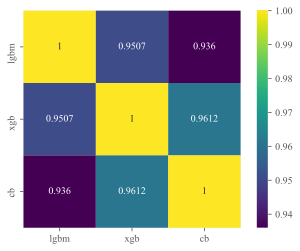

In [47]:
plt.figsize=(7, 7)
sns.heatmap(corr, annot=True, fmt=".4g", square=True, cmap="viridis")
plt.show()

In [43]:
prediction_cb = np.zeros(test.shape[0])
for model in estimators_cb:
    prediction_cb+=model.predict_proba(test_dum)[:, 1]
prediction_cb = prediction_cb/len(estimators_cb)

In [44]:
scores_preds = pd.DataFrame({
    "lgbm": prediction_lgbm,
    "xgb": prediction_xgb,
    "cb": prediction_cb  
})

corr = scores_preds.corr()

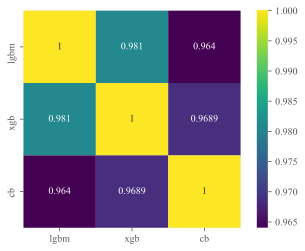

In [45]:
plt.figsize=(7, 7)
sns.heatmap(corr, annot=True, fmt=".4g", square=True, cmap="viridis")
plt.show()

Больше шансов, что блендинг этих моделей даст эффект. 

***************************

4) Выполнить задание 2 для трех моделей.

**AMean**

In [48]:
scores_mean = scores.mean(axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7206


**GMean**

In [49]:
scores_mean = gmean(scores, axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7207


**Rankdata**

In [50]:
scores_mean = scores.rank().mean(axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7204


In [51]:
scores_mean = gmean(scores.rank(), axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7205


Gmean показал лучшую метрику. Однако среди моделей lgbm показал результат лучше - для блендинга стоит подбирать веса предсказаний